In [1]:
# Imports 
import csv
import math 
import time
import random
import ortools 
import datetime 
import matplotlib 
import numpy as np
import pandas as pd
import configparser 
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans 
from geopy.geocoders import Nominatim 

In [2]:
random.seed(1234)
plt.rcParams['figure.figsize'] = (10,7.5) 

flag = 2
w1, w2 = 0.5, 0.5 

---
**flag** :  
It decides which distance metric/measure to consider:   
0: euclidean distance (or physical distance)   
1: rating   
2: combination of euclidean distance and rating    
   for which, 'w1' is weight given to euclidean distance and 'w2' is weight given to distance    
   
---

**Hyperparameters** :
- 'state' variable in config.cfg selects the dataset. It can take values in {'RJ', 'MG', 'SP'}
- 'fair_distance' variable in config.cfg controls the fair distance considered in the LP. The results presented in the paper correspond to the following fair_distance values:
    - 'fair_distance' for (flag=0 | flag=1 | flag=2) 
        - RJ : ( | | )
        - MG : ( | | )
        - SP : ( | | )

---

In [3]:
# Setting up configParser:
configParser = configparser.RawConfigParser()   
configFilePath = 'config.cfg' 
configParser.read(configFilePath)
print("Configuration file read done !")


# File paths
customer_dir = configParser.get('file-paths','customer_dir')
geolocation_dir = configParser.get('file-paths','geolocation_dir')
seller_dir = configParser.get('file-paths','seller_dir')
order_dir = configParser.get('file-paths','order_dir')
order_item_dir = configParser.get('file-paths','order_item_dir')
print("File Paths obtained !")

# Creating dataframes
customer_df = pd.read_csv(customer_dir)
location_df = pd.read_csv(geolocation_dir)
seller_df = pd.read_csv(seller_dir)
order_df = pd.read_csv(order_dir)
order_item_df = pd.read_csv(order_item_dir)

# more work for location dataframe:
state_or_city = configParser.get('dataset-generation','state_or_city') 
city_dataset = configParser.get('dataset-generation','city')           
state_dataset = configParser.get('dataset-generation','state')         
equal_or_not = int(configParser.get('dataset-generation','equal_to'))   

if state_or_city == 'state':
  if equal_or_not == 1:
    location_df = location_df[location_df['geolocation_state']==state_dataset]
  else:
    location_df = location_df[location_df['geolocation_state']!=state_dataset]
else:
  if equal_or_not == 1:
    location_df = location_df[location_df['geolocation_city']==city_dataset]
  else:
    location_df = location_df[location_df['geolocation_city']!=city_dataset]

# consider only zip code prefix level info (not fine-grained till lat-lng level)
# Finally, location_df contains locations of the state "state_dataset"
location_df = location_df.drop_duplicates('geolocation_zip_code_prefix')

# Processing "order_df" 
# Take only 'delivered' orders with known delivery dates 
order_df = order_df[order_df['order_status']=='delivered']
order_df = order_df[order_df['order_delivered_customer_date'].notna()]
order_df['order_delivered_customer_date'] = pd.to_datetime(order_df['order_delivered_customer_date'])
# Take only delivery dates, not delivery time
order_df['order_delivered_customer_date'] = order_df['order_delivered_customer_date'].dt.date
# Clubbing multiple dates into one, because the data for a single day is too small
club_num_dates = int(configParser.get('dataset-generation','club_num_dates')) # 16 (first 15 days will be mapped to 1st day and last 15-16 days will be mapped to 17th day)

def club_date(dt,club_num_dates):
  if(club_num_dates > 30): # monthwise clubbing is the intention
    return pd.datetime(dt.year, dt.month, 1)
  return pd.datetime(dt.year, dt.month, int(dt.day/club_num_dates)*club_num_dates+1) 

order_df['order_delivered_customer_date'] = order_df['order_delivered_customer_date'].map(lambda x: club_date(x,club_num_dates))

order_df = order_df.sort_values("order_delivered_customer_date")
order_df = order_df.reset_index()


# Merging DataFrames
overall_customer_df = pd.merge(customer_df,order_df,on='customer_id')
overall_customer_loc_df = pd.merge(overall_customer_df,location_df,left_on='customer_zip_code_prefix',right_on='geolocation_zip_code_prefix')

print("customer_df.shape:", customer_df.shape)
print("order_df.shape:", order_df.shape)
print("overall_customer_df.shape:", overall_customer_df.shape)
print("location_df.shape:", location_df.shape)
print("overall_customer_loc_df.shape:", overall_customer_loc_df.shape)

Configuration file read done !
File Paths obtained !


/tmp/ipykernel_3825593/2136004698.py:57: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  return pd.datetime(dt.year, dt.month, int(dt.day/club_num_dates)*club_num_dates+1)


customer_df.shape: (99441, 5)
order_df.shape: (96470, 9)
overall_customer_df.shape: (96470, 13)
location_df.shape: (6349, 5)
overall_customer_loc_df.shape: (40480, 18)


In [4]:
"""Training Data"""
training_data_percent = int(configParser.get('dataset-generation','training_data_percent'))
print("Training data percentage:", training_data_percent)

start_date_loc = int(0.1*len(order_df.index)) 
start_training_date = order_df["order_delivered_customer_date"].iloc[start_date_loc]
end_date_loc = int((10+training_data_percent)/100*len(order_df.index))
end_training_date = order_df["order_delivered_customer_date"].iloc[end_date_loc]

training_order_df = order_df[order_df['order_delivered_customer_date']<=end_training_date]
training_order_df = training_order_df[order_df['order_delivered_customer_date']>=start_training_date]
num_training_days = training_order_df['order_delivered_customer_date'].nunique()

training_customer_df = pd.merge(customer_df,training_order_df,on='customer_id') 
training_customer_df = training_customer_df.drop_duplicates('customer_unique_id')

training_order_item_df = pd.merge(order_item_df,training_order_df,on='order_id')
training_seller_df = pd.merge(seller_df,training_order_item_df,on='seller_id')
training_seller_df = training_seller_df.drop_duplicates('seller_id')

training_customer_loc_df = pd.merge(training_customer_df, location_df,left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix')
training_seller_loc_df = pd.merge(training_seller_df, location_df,left_on='seller_zip_code_prefix', right_on='geolocation_zip_code_prefix')

training_customer_loc_df.rename(columns = {'customer_city':'city'}, inplace = True)
training_seller_loc_df.rename(columns = {'seller_city':'city'}, inplace = True)

training_customer_locations = training_customer_loc_df[['geolocation_lat','geolocation_lng','city']]
training_seller_locations = training_seller_loc_df[['geolocation_lat','geolocation_lng','city']]

training_combined_locations = pd.concat([training_customer_locations,training_seller_locations])

Training data percentage: 20


/tmp/ipykernel_3825593/143425589.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  training_order_df = training_order_df[order_df['order_delivered_customer_date']>=start_training_date]


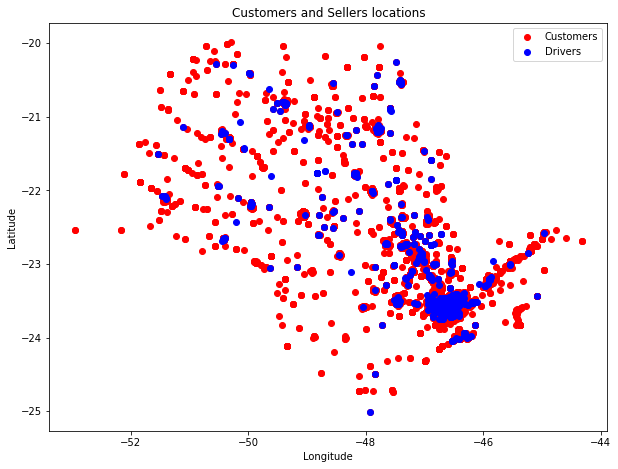

In [5]:
"""Finding maximum and minimum capacity of a warehouse for training data"""
lis = ['geolocation_lat','geolocation_lng']

# Customers
customer_locs = training_customer_locations[lis].values
customer_locs = np.transpose(customer_locs)
c_lts, c_lngs = customer_locs[0], customer_locs[1] 
plt.scatter(c_lngs,c_lts,color='Red',label='Customers')

# Sellers
seller_locs = training_seller_locations[lis].values
seller_locs = np.transpose(seller_locs)
s_lts, s_lgs = seller_locs[0], seller_locs[1]
# plt.scatter(s_lgs,s_lts,color='Blue',label='Sellers')
plt.scatter(s_lgs,s_lts,color='Blue',label='Drivers')

plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Customers and Sellers locations')
plt.show()

In [6]:
"""Test Data""" 
testing_order_df = order_df[order_df['order_delivered_customer_date'] > start_training_date]
testing_customer_df = pd.merge(customer_df,testing_order_df,on='customer_id')
testing_customer_df = testing_customer_df.drop_duplicates('customer_unique_id')
testing_customer_loc_df = pd.merge(testing_customer_df, location_df,left_on = 'customer_zip_code_prefix' ,right_on='geolocation_zip_code_prefix')
num_testing_days = testing_customer_loc_df['order_delivered_customer_date'].nunique()

testing_order_item_df = pd.merge(order_item_df,training_order_df,on='order_id')
testing_seller_df = pd.merge(seller_df,testing_order_item_df,on='seller_id')
testing_seller_df = testing_seller_df.drop_duplicates('seller_id')
testing_seller_loc_df = pd.merge(testing_seller_df, location_df,left_on = 'seller_zip_code_prefix' ,right_on='geolocation_zip_code_prefix')

lat_mean = training_combined_locations['geolocation_lat'].mean()
lat_std = training_combined_locations['geolocation_lat'].std()

testing_customer_loc_df = testing_customer_loc_df[(testing_customer_loc_df['geolocation_lat']-lat_mean)< 3*lat_std]
testing_customer_loc_df = testing_customer_loc_df[(testing_customer_loc_df['geolocation_lat']-lat_mean)> -3*lat_std]

lng_mean = training_combined_locations['geolocation_lng'].mean()
lng_std = training_combined_locations['geolocation_lng'].std()

testing_customer_loc_df = testing_customer_loc_df[(testing_customer_loc_df['geolocation_lng']-lng_mean)< 3*lng_std]
testing_customer_loc_df = testing_customer_loc_df[(testing_customer_loc_df['geolocation_lng']-lng_mean)> -3*lng_std]

testing_customer_loc_df = testing_customer_loc_df.reset_index(drop=True)

In [7]:
"""Facility Location to get the 'k' warehouse locations"""
from shapely import geometry

def random_loc_generator(c_locs):
  lats, longs = c_locs[0], c_locs[1]
  coords = [(x,y) for x,y in zip(lats, longs)]
  min_lat, max_lat = min(lats), max(lats)
  min_lng, max_lng = min(longs), max(longs)
  new_lat, new_lng = random.uniform(min_lat, max_lat), random.uniform(min_lng, max_lng) 
  return [new_lat, new_lng]


def loc_in_zone(loc, c_locs):
  lats, longs = c_locs[0], c_locs[1]
  coords = [(x,y) for x,y in zip(lats, longs)]
  polygon = geometry.MultiPoint(coords).convex_hull
  Point_X, Point_Y = loc[0], loc[1]
  point = geometry.Point(Point_X, Point_Y)
  return point.within(polygon)

# code to generate 'm' locations that lie within a given zone:
def generate_locs(m, c_locs):
    new_locs = []
    num_generated = 0
    while num_generated < m:
        new_loc = random_loc_generator(c_locs)
        sanity_check = loc_in_zone(new_loc, c_locs)
        if sanity_check:
            num_generated += 1
            new_locs.append(new_loc)
    return new_locs

num_potential_locs = 100
potential_locs = np.array(generate_locs(num_potential_locs, customer_locs))

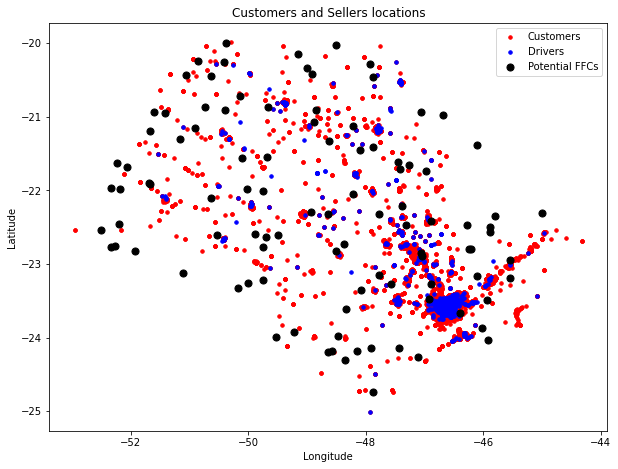

In [8]:
# Plot Customers and Sellers 
lis = ['geolocation_lat','geolocation_lng']

# Customers
customer_locs = training_customer_locations[lis].values
customer_locs = np.transpose(customer_locs)
c_lts, c_lngs = customer_locs[0], customer_locs[1] 
plt.scatter(c_lngs,c_lts,color='Red',label='Customers', s=12)

# Sellers
seller_locs = training_seller_locations[lis].values
seller_locs = np.transpose(seller_locs)
s_lts, s_lgs = seller_locs[0], seller_locs[1]
# plt.scatter(s_lgs,s_lts,color='Blue',label='Sellers')
plt.scatter(s_lgs,s_lts,color='Blue',label='Drivers', s=12)

# Potenital Warehouse locations
p_lts, p_lgs = potential_locs[:, 0], potential_locs[:, 1]
plt.scatter(p_lgs, p_lts, color='Black', label='Potential FFCs', s=50)

plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Customers and Sellers locations')
plt.show()

In [9]:
# Customer locations
cust_lats, cust_lngs = customer_locs[0], customer_locs[1]
cust_locs = np.array([[lat, lng] for lat, lng in zip(cust_lats, cust_lngs)])
# potential ffc/warehouse locations
pffc_locs = np.array(potential_locs)
# cost per mile
cost_per_mile = 1

In [10]:
# Problem: Find the locations of the ffcs
# Model: k-median variant of the Uncapacitated Facility Location Problem (UCFL)
from itertools import product

import gurobipy as gb
from gurobipy import GRB

# fucntion to calculate euclidean distance b/w facilty and customer sites
def compute_distance(loc1, loc2):
    dx = loc1[0] - loc2[0]
    dy = loc1[1] - loc2[1]
    return np.sqrt(dx*dx + dy*dy)

# Key parameters of MIP model formulation
num_facilities = pffc_locs.shape[0]
num_customers = cust_locs.shape[0]
cartesian_prod = list(product(range(num_customers), range(num_facilities))) # [num_customers x num_facilities]

# Delivering / Shipping costs:
delivery_cost = {(c, f): cost_per_mile*compute_distance(cust_locs[c], pffc_locs[f]) for c, f in cartesian_prod}
cost_matrix = np.array(list(delivery_cost.values())).reshape((num_customers, num_facilities))

In [11]:
# MIP model formulation 
# select k-ffc locations from the given set of potential locations
def kmedian(m, n, c, k):
    '''
    m: number of potential locations
    n: number of customers
    c: cost matrix
    k: required number of ffcs/warehouses
    '''
    model = gb.Model("k-median")
    dem, fac = list(range(n)), list(range(m)) # facility and demand
    
    # VARIABLES:
    assign = model.addVars(dem, fac)
    select = model.addVars(fac, vtype=GRB.BINARY)  
    # OBJECTIVE: 
    model.setObjective(gb.quicksum(c[i, j]*assign[i, j] for j in fac for i in dem), GRB.MINIMIZE)
    # CONSTRAINTS:
    model.addConstrs(gb.quicksum(assign[i, j] for j in fac)==1 for i in dem)
    model.addConstr(gb.quicksum(select)==k)
    model.addConstrs(assign[i, j] <= select[j] for j in fac for i in dem)
    model.update() 
    model.Params.Method = 3
    model.optimize()
    
    return model, assign, select

In [12]:
num_ffc_center = int(configParser.get('dataset-generation', 'num_ffc_center'))
_, assignz, selected_ffcs = kmedian(num_facilities, num_customers, cost_matrix, num_ffc_center) 

mask_ffcs = [abs(int(val.x)) for val in selected_ffcs.values()]
mask_ffc = np.array([True if val==1 else False for val in mask_ffcs])
final_ffc_locs = potential_locs[mask_ffc]

assert sum(mask_ffcs)==num_ffc_center, "The number of selected ffcs < required_num_ffc"

# find out which customers are assigned to which ffc:
cust_ffc_map = {key:abs(int(val.x)) for key, val in assignz.items()}
cust_ffc_map = {cust: ffc for (cust, ffc) in assignz.keys() if cust_ffc_map[(cust, ffc)]==1}

old_indices = np.unique(np.array(list(cust_ffc_map.values()))) # indices of the selected warehouses in 'potential_locs'
new_indices = list(range(num_ffc_center)) # indices of the warehouses in 'final_ffc_locs'
idx_map = {oidx:nidx for oidx, nidx in zip(old_indices, new_indices)}

for i in cust_ffc_map.keys():
    old_val = cust_ffc_map[i]
    cust_ffc_map[i] = idx_map[old_val]


# assigning ffc in testing data:
num_facilities = pffc_locs.shape[0]
num_cust = cust_locs.shape[0]
cartesian_prod = list(product(range(num_cust), range(num_facilities))) # [num_customers x num_facilities]

# Delivering / Shipping costs:
delivery_cost = {(c, f): cost_per_mile*compute_distance(cust_locs[c], pffc_locs[f]) for c, f in cartesian_prod}
cost_matrix = np.array(list(delivery_cost.values())).reshape((num_cust, num_facilities))

# Assigning FFC to each customer 
## Assign a customer to the nearest ffc:
ffc_indices = []
for idx in range(testing_customer_loc_df.shape[0]):
    # print(idx)
    c_loc = testing_customer_loc_df.iloc[idx][lis]
    
    min_dist = 1e9
    ffc_idx = -1
    for fidx in range(final_ffc_locs.shape[0]):
        f_loc = final_ffc_locs[fidx]
        dist = compute_distance(c_loc, f_loc)
        if(dist < min_dist):
            ffc_idx = fidx 
            min_dist = dist 
    ffc_indices.append(ffc_idx)


lis = ['geolocation_lat','geolocation_lng']

test_prediction = np.array(ffc_indices)
testing_customer_loc_df['ffc_index'] = test_prediction
testing_customer_loc_df = testing_customer_loc_df.sort_values('order_delivered_customer_date')

Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-08
Set parameter Method to value 3
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 20 physical cores, 40 logical processors, using up to 20 threads
Optimize a model with 849916 rows, 841600 columns and 2524600 nonzeros
Model fingerprint: 0x40d2169c
Variable types: 841500 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-03, 8e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Presolve removed 487931 rows and 483100 columns (presolve time = 5s) ...
Presolve removed 487931 rows and 483100 columns
Presolve time: 7.57s
Presolved: 361985 rows, 358500 columns, 1075300 nonzeros
Variable types: 358400 continuous, 100 integer (100 binary)
Found heuristic solution: objective 7820.0002132
Found heuristic solution: objective 7723.0097250

Concurrent LP optimizer: primal simplex, dual simplex, and bar

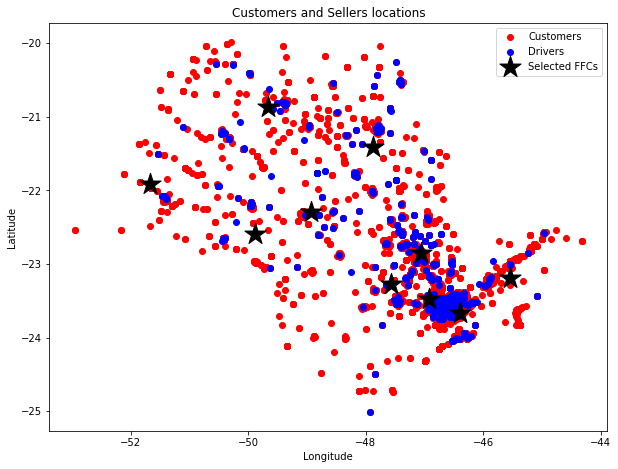

In [13]:
# Plot Customers and Sellers 
lis = ['geolocation_lat','geolocation_lng']

# Customers
customer_locs = training_customer_locations[lis].values
customer_locs = np.transpose(customer_locs)
c_lts, c_lngs = customer_locs[0], customer_locs[1] 
plt.scatter(c_lngs,c_lts,color='Red',label='Customers')

# Sellers
seller_locs = training_seller_locations[lis].values
seller_locs = np.transpose(seller_locs)
s_lts, s_lgs = seller_locs[0], seller_locs[1]
# plt.scatter(s_lgs,s_lts,color='Blue',label='Sellers')
plt.scatter(s_lgs,s_lts,color='Blue',label='Drivers')

# Potenital Warehouse locations
p_lts, p_lgs = final_ffc_locs[:, 0], final_ffc_locs[:, 1]
plt.scatter(p_lgs, p_lts, color='Black', label='Selected FFCs', marker="*", s=500)

plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Customers and Sellers locations')
plt.show()

In [14]:
label_ = pd.DataFrame(columns={'label', 'x', 'y'})
label_['label'] = list(range(num_ffc_center))
label_['x'] = final_ffc_locs[:, 0]
label_['y'] = final_ffc_locs[:, 1]

In [15]:
# Finding maximum and minimum capacity of a warehouse for training data
lis = ['geolocation_lat','geolocation_lng']
prediction_array = np.array(list(cust_ffc_map.values()))
training_customer_loc_df['ffc_index'] = prediction_array

# Finding the number of orders of particular ffc center for each date
training_customer_group_date = training_customer_loc_df.groupby(['ffc_index','order_delivered_customer_date'])['order_id'].count()
training_customer_group_date = pd.DataFrame({'count':training_customer_group_date}).reset_index()

# Finding 'quantile_capacity'-th quantile values for each ffc wrt the number of order over all dates
quantile_capacity=float(configParser.get('dataset-generation','qauntile_capacity')) 

training_customer_group_date = training_customer_group_date.groupby(['ffc_index'])['count'].quantile(quantile_capacity)
training_customer_group_date = pd.DataFrame({'cap':training_customer_group_date}).reset_index()

# For each ffc:
training_customer_group_date['min_cap'] = np.ceil(0.3 * training_customer_group_date['cap'])
training_customer_group_date['max_cap'] = np.ceil(1.0 * training_customer_group_date['cap'])
training_customer_group_date = training_customer_group_date.sort_values('ffc_index')

max_cap = training_customer_group_date['max_cap'].values
min_cap = training_customer_group_date['min_cap'].values

Number of Drivers: 394


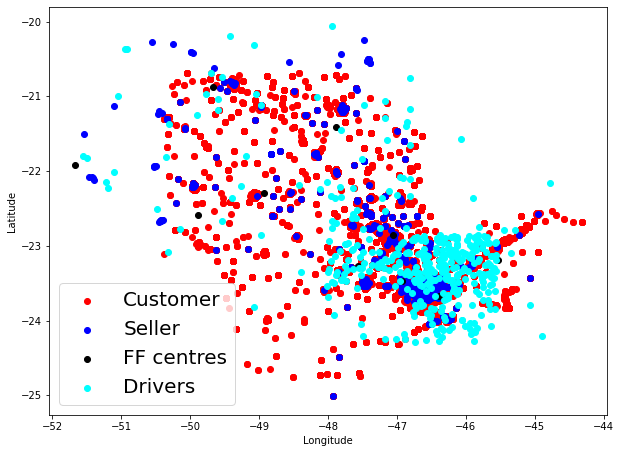

Drivers' Locations:
 [[-23.81728879 -49.07425473]
 [-24.17611856 -46.90168688]
 [-24.25049617 -47.00922859]
 [-24.23914621 -47.17195445]
 [-24.05048251 -47.52033528]
 [-23.68708696 -47.99664986]
 [-24.24908662 -46.89050653]
 [-23.926864   -47.9073448 ]
 [-23.58302271 -46.85141596]
 [-24.2118824  -47.49739339]
 [-24.06806896 -46.01882612]
 [-24.17521489 -45.92580831]
 [-24.25586798 -46.57439428]
 [-23.70628891 -46.29144531]
 [-23.99163745 -46.05026821]
 [-23.94998602 -46.31111105]
 [-24.27086597 -45.88941569]
 [-23.59716951 -45.58095896]
 [-23.81565305 -46.34595293]
 [-24.03169526 -45.93410045]
 [-23.80833574 -46.64520006]
 [-24.12384211 -46.33734347]
 [-23.92512068 -45.78603632]
 [-23.9332732  -46.75093562]
 [-23.70134926 -46.25487656]
 [-23.91962247 -46.51152009]
 [-23.98559564 -46.30658898]
 [-23.73776695 -46.65904395]
 [-23.89735149 -46.56595974]
 [-23.79242906 -46.74019683]
 [-24.0939487  -46.36096596]
 [-23.83482673 -46.72142518]
 [-23.96257334 -46.52802349]
 [-24.09010326 -46.197

In [16]:
import random

def driver_generation(seed_val):
  '''
  Creating drivers through grid formation:
  - Divide the city into an MxN grid
  - Number of drivers in a grid cell = rand_num * number of customers in the grid cell
      where rand_num is a random number in range [0.5, 1.5]
  '''

  lis = ['geolocation_lat', 'geolocation_lng']
    
  # the drivers' locations are predicted based on the training data
  # for making the grid we use combined_locs
  combined_locs = training_combined_locations[lis].values 
  combined_locs = np.transpose(combined_locs)
    
  # for getting the number of customers in each grid cell we use customer_locs
  customer_locs = training_customer_loc_df[lis].values
  customer_locs = np.transpose(customer_locs)
  
  # min- and max-longitude values
  min_long, max_long = np.amin(combined_locs[0]), np.amax(combined_locs[0])
  # min- and max-lattitude values
  min_lat, max_lat = np.amin(combined_locs[1]), np.amax(combined_locs[1])

  # configParser.read(configFilePath)
  prop_constant_driver_customer = float(configParser.get('dataset-generation','prop_constant_driver_customer'))
  grid_length = int(configParser.get('dataset-generation','grid_length'))
  grid_width = int(configParser.get('dataset-generation','grid_width'))   
  prop_constant_lower_range = float(configParser.get('dataset-generation','prop_constant_lower_range'))  # 0.5 
  prop_constant_higher_range = float(configParser.get('dataset-generation','prop_constant_upper_range')) # 1.5

  random.seed(seed_val) 
    
  # Making the grid:  
  grid_size=[grid_length,grid_width]
  
  drivers=[[],[]]
  sum_customer = 0
  sum_driver = 0

  for i in range(grid_size[0]):
    left_long = min_long + ((max_long-min_long)/grid_size[0])*i
    right_long = min_long + ((max_long-min_long)/grid_size[0])*(i+1)
    ind1 = customer_locs[0]>=left_long  
    ind2 = customer_locs[0]<=right_long

    for j in range(grid_size[1]):
      up_lat = min_lat + ((max_lat-min_lat)/grid_size[1])*(j+1)
      down_lat = min_lat + ((max_lat-min_lat)/grid_size[1])*j
      ind3 = customer_locs[1]>=down_lat
      ind4 = customer_locs[1]<=up_lat 
      ind = ind1 & ind2 & ind3 & ind4
      num_customers = np.count_nonzero(ind) / num_training_days
      num_drivers = num_customers / prop_constant_driver_customer

      random_constant = random.uniform(prop_constant_lower_range,prop_constant_higher_range) 
      num_drivers = int(num_drivers * random_constant)
      
      if num_drivers==0:
        continue
      for k in range(num_drivers):
        drivers[0].append(random.uniform(left_long,right_long))
        drivers[1].append(random.uniform(down_lat,up_lat))
    
      sum_driver += num_drivers
      sum_customer += num_customers   
  drivers = np.array(drivers)

  print("Number of Drivers:",len(drivers[0]))
  new_drivers = np.transpose(drivers)
  
  # Plot Customers, Sellers, FFCs and Drivers
  fig, ax = plt.subplots()
  
  # Customers
  customer_locs = testing_customer_loc_df[lis].values
  customer_locs = np.transpose(customer_locs)
  c_lts, c_lngs = customer_locs[0], customer_locs[1]
  plt.scatter(c_lngs,c_lts,color='Red',label='Customer')
 
  # Sellers
  seller_locs = testing_seller_loc_df[lis].values
  seller_locs = np.transpose(seller_locs)
  s_lts, s_lngs = seller_locs[0], seller_locs[1]
  plt.scatter(s_lngs,s_lts,color='Blue',label='Seller')
  
  # FFCs
  # ffc_locs = np.transpose(centre)
  ffc_locs = np.transpose(final_ffc_locs)
  f_lts, f_lngs = ffc_locs[0], ffc_locs[1]
  plt.scatter(f_lngs,f_lts,color='Black',label='FF centres')
    
  # Drivers
  driver_locs = drivers
  d_lts, d_lngs = driver_locs[0], driver_locs[1]
  plt.scatter(d_lngs,d_lts,color='Cyan',label='Drivers')
  
  plt.legend(loc='lower left',prop={'size':20})
  plt.xlabel('Longitude')
  plt.ylabel('Latitude')
  # plt.savefig("Plots/Coordinate Plots/"+state_dataset+".pdf")
  plt.show()
  plt.close()

  return new_drivers

# Generating Drivers
driver_locs = driver_generation(12)
print("Drivers' Locations:\n", driver_locs)

Number of Drivers: 350


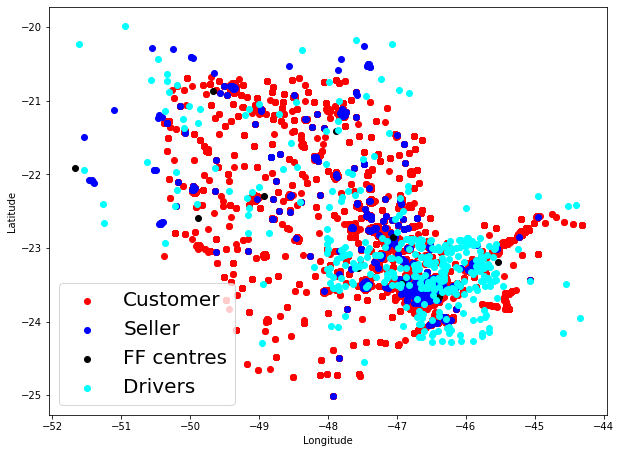

In [17]:
s_lats, s_lngs = seller_locs[0], seller_locs[1]
driver_locs = np.array([[lat, lng] for lat, lng in zip(s_lats, s_lngs)])

def L2Distance(data):
  # "data": latitude-longitude level locations 
  transposed = np.expand_dims(data, axis = 1)
  distance = np.power(data - transposed, 2)
  distance = np.power(np.abs(distance).sum(axis = 2), 0.5) 
  return distance 

# assigning ratings to sellers:
import random
def generate_ratings(num_drivers):
    r_set = list(np.arange(0, 6, 0.1)) #[1, 2, 3, 4, 5]
    ratings = [0.0]*num_drivers
    for i in range(num_drivers):
        ratings[i] = np.round(random.sample(r_set, 1)[0],1)
    return ratings
  
def abs_difference(ratings):
    transposed = np.expand_dims(ratings, axis=1)
    diff = abs(ratings-transposed) 
    return diff

# new_drivers = driver_locs
new_drivers = driver_generation(3249+1)
ratings_list = generate_ratings(new_drivers.shape[0]) 

In [18]:
# Using max flow for the Vanilla Distribution of Drivers to the warehouse
import networkx as nx
from networkx.algorithms.flow import maximum_flow
from math import cos, asin, sqrt, pi

# Haversine formula
# angular distance between two points on the surface of a sphere 
# Refer: https://stackoverflow.com/questions/27928/calculate-distance-between-two-latitude-longitude-points-haversine-formula
def distance(lat1, lon1, lat2, lon2):
    p = pi/180
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p) * cos(lat2*p) * (1-cos((lon2-lon1)*p))/2
    return 12742 * asin(sqrt(a))
    
prop_constant_driver_customer=float(configParser.get('dataset-generation','prop_constant_driver_customer'))

# Since prop_constant_driver_customer number of orders (or customers) are being mapped to one driver
# so upper_cap and lower_cap (wrt drivers) of each FFC will be (1/prop_constant_driver_customer) times max_cap and min_cap (wrt orders (or customers))
upper_cap = max_cap / prop_constant_driver_customer
lower_cap = min_cap / prop_constant_driver_customer
lower_cap = lower_cap.astype(int)
upper_cap = upper_cap.astype(int)
upper_cap = np.array(upper_cap)
lower_cap = np.array(lower_cap)
lower_cap[lower_cap<=0] = 1   


'''
MCCA (Minimum Cost Capacitated Assignment) problem !
- It can be cast as a "minimum cost b-matching problem" in bipartite graphs
- The "min cost b-matching problem" reduces to thte classical "min cost flow problem"
'''
"""Code to generate MCCA distribution using networkX library"""
# only upper_cap respected, lower_cap not included
def flow_with_max_capacity(driver_loc,centre):
  G = nx.DiGraph()
  num_variables = len(centre) + len(driver_loc)
  for i in range(len(driver_loc)):
    G.add_edge(1,i+2,capacity=1,weight=0)

  for i in range(len(centre)):
    G.add_edge(len(driver_loc)+1+(i+1),num_variables+2,capacity=int(upper_cap[i]),weight=0)

  for i in range(len(driver_loc)):
    for j in range(len(centre)):
      dis = (driver_loc[i][0]-centre[j][0])**2 + (driver_loc[i][1]-centre[j][1])**2 
      G.add_edge(i+2,len(driver_loc)+1+(j+1),capacity=1,weight=int(dis*1000))
    
  mincostFlow = nx.max_flow_min_cost(G, 1, num_variables+2) 
  minCost = nx.cost_of_flow(G, mincostFlow) 
  maxFlow = maximum_flow(G, 1, num_variables+2)[1]
  maxflowValue = nx.maximum_flow_value(G,1,num_variables+2)

  driver_df = pd.DataFrame(driver_loc,columns=["geolocation_lat","geolocation_lng"])
  driver_df['ffc_index'] = -1 # unassigned 
  
  # Driver to ffc assignment based on a mincostFlow values from corresponding driver_node to ffc_nodes
  for i in range(len(driver_loc)):
    for j in range(len(centre)):
      if abs(mincostFlow[i+2][len(driver_loc)+(j+2)] - 1) < 0.1: 
        driver_df.at[i,'ffc_index'] = j
  
  return driver_df



'''Code to generate MCCA distribution using ortools library'''
# lower_cap and upper_cap both considered
from ortools.graph import pywrapgraph

def flow_with_maxmin_capacity(driver_loc,centre):
  '''
  - Instantiate a "SimpleMinCostFlow" solver.
  - Using min-max flow for the Vanilla Distribution of Drivers to the warehouse
  '''
  num_variables = len(centre) + len(driver_loc)
  
  min_cost_flow = pywrapgraph.SimpleMinCostFlow()
  for i in range(len(driver_loc)):
    min_cost_flow.AddArcWithCapacityAndUnitCost(1,i+2,1,0)

  for i in range(len(driver_loc)):
    for j in range(len(centre)):
      dis=(driver_loc[i][0]-centre[j][0])**2 + (driver_loc[i][1]-centre[j][1])**2
      min_cost_flow.AddArcWithCapacityAndUnitCost(i+2,len(driver_loc)+1+(j+1),1,int(dis*1000))

  for i in range(len(centre)):
    min_cost_flow.AddArcWithCapacityAndUnitCost(len(driver_loc)+1+(i+1),num_variables+2,int(upper_cap[i])-int(lower_cap[i]),0)
  for i in range(0,len(centre)): 
    min_cost_flow.SetNodeSupply(len(driver_loc)+1+(i+1), -int(lower_cap[i]))

  source_supply = int(len(driver_loc))
  sink_supply = int(len(driver_loc)-np.sum(lower_cap))

  min_cost_flow.SetNodeSupply(1,source_supply)
  min_cost_flow.SetNodeSupply(num_variables+2,-sink_supply)

  for i in range(0,len(driver_loc)):
    min_cost_flow.SetNodeSupply(i+2,0)

  if min_cost_flow.Solve() == min_cost_flow.OPTIMAL:
      print('Minimum cost:', min_cost_flow.OptimalCost())
      print('')
      print('  Arc    Flow / Capacity  Cost')
      for i in range(min_cost_flow.NumArcs()):
        if min_cost_flow.Flow(i)!=0:
          cost = min_cost_flow.Flow(i) * min_cost_flow.UnitCost(i)
          print('%1s -> %1s   %3s  / %3s       %3s' % (
              min_cost_flow.Tail(i),
              min_cost_flow.Head(i),
              min_cost_flow.Flow(i),
              min_cost_flow.Capacity(i),
              cost))
  else:
    print('There was an issue with the min cost flow input.')

  driver_df1 = pd.DataFrame(driver_loc,columns=["geolocation_lat","geolocation_lng"])
  driver_df1['ffc_index'] = -1 # unassigned
  
  for i in range(min_cost_flow.NumArcs()):
    if min_cost_flow.Flow(i)!=0 and min_cost_flow.Tail(i)!=1 and min_cost_flow.Head(i)!=(num_variables+2):
      tail = min_cost_flow.Tail(i)
      head = min_cost_flow.Head(i)
      driver_df1.at[tail-2,'ffc_index'] = head-len(driver_loc)-2  # (head-len(driver_loc)-2) is ffc_label ! -len(driver_loc)-2 ensures that it's in {0, ..., (num_ffc-1)} 
  return driver_df1

In [19]:
from cplex import Cplex
model = Cplex()
model.parameters.simplex.tolerances.feasibility.get(),\
model.parameters.simplex.tolerances.optimality.get(),\
model.parameters.simplex.tolerances.markowitz.get()

(1e-06, 1e-06, 0.01)

In [20]:
# Fair Clustering - LPP contstraints and Cplex
from cplex import Cplex
from lp_tools import *

# configParser.read(configFilePath)
# fair_distance = int(configParser.get('fairness-constraint','fair_distance'))
fair_distance = float(configParser.get('fairness-constraint','fair_distance'))
alpha_fair = float(configParser.get('fairness-constraint','alpha_fair'))

# fair_distance = 1e9 # uncomment to consider "global fairness constraints" #cwp
# alpha_fair = 2 #cwp

def fair_clustering(dataset, centres,ratings):

  # Step 1: 	 Create an instance of Cplex 
  problem = Cplex()
  
  ## changing tolerances to improve solution quality (prevent ill-conditioning and avoid numerical instability)
  ## https://www.ibm.com/docs/en/icos/20.1.0?topic=cplex-list-parameters
  problem.parameters.simplex.tolerances.feasibility.set(float(1e-9))
  problem.parameters.simplex.tolerances.optimality.set(float(1e-9))
  problem.parameters.simplex.tolerances.markowitz.set(float(0.9))
  

  # Step 2: 	 Declare that this is a minimization problem
  problem.objective.set_sense(problem.objective.sense.minimize)
    
  """
   Step 3.   Declare and  add variables to the model. 
        The function prepare_to_add_variables (dataset, centres) prepares all the required information for this stage.
  
    objective: a list of coefficients (float) in the linear objective function
    lower bound: a list of floats containing the lower bounds for each variable
    upper bound: a list of floats containing the upper bounds for each variable
    variable_names: a list of strings that contains the name of the variables
  """
  objective, lower_bound, upper_bound, variable_names, P,C = prepare_to_add_variables(dataset, centres)
  problem.variables.add(
      obj = objective,
      lb = lower_bound,
      ub = upper_bound,
      names = variable_names
     
    )
    
  """
  Step 4.   Declare and add constraints to the model.
            There are few ways of adding constraints: row wise, col wise and non-zero entry wise.
            Assume the constraint matrix is A. We add the constraints non-zero entry wise.
            The function prepare_to_add_constraints(dataset, centres) prepares the required data for this step.
  
   coefficients: Three tuple containing the row number, column number and the value of the constraint matrix
   senses: a list of strings that identifies whether the corresponding constraint is
           an equality or inequality. "E" : equals to (=), "L" : less than (<=), "G" : greater than equals (>=)
   rhs: a list of floats corresponding to the rhs of the constraints.
   constraint_names: a list of string corresponding to the name of the constraint
  """
  rhs, senses, row_names, coefficients = prepare_to_add_constraints(dataset, centres, upper_cap,lower_cap, P,C, alpha_fair,fair_distance,ratings,flag)
  print("num_constraints:", len(senses))
  problem.linear_constraints.add(
      rhs = rhs,
      senses = senses,
      names = row_names
    )
  problem.linear_constraints.set_coefficients(coefficients)

  # Step 5.	Solve the problem
  problem.solve()

  result = {
    "status": problem.solution.get_status(),
    "success": problem.solution.get_status_string(),
    "objective": problem.solution.get_objective_value(),
    "assignment": problem.solution.get_values(),
  }
    
  qm = problem.solution.quality_metric  
  print("Solution Quality:", problem.solution.get_float_quality([qm.max_x, qm.max_primal_infeasibility]))
  # qm.max_primal_infeasibility is the "maximum bound violation" across all parameters
  # print("Solution Kappa:", )
  
  # print("Status:", result['status'])
  print("Status:", problem.solution.get_status_string())

  feasibility = 0
  if problem.solution.get_status_string()=='optimal':
        feasibility = 1
  return result, feasibility

In [21]:
# Caluclate average distance each driver has to travel each day from going to home to the location of FF Center
def average_distance(driver_dist, label):
    distance_warehouse_driver_df = pd.merge(driver_dist, label, left_on = 'ffc_index' ,right_on='label')
    dist1=0.0
    for i in range(len(distance_warehouse_driver_df)):
        dist1 = dist1 + math.sqrt((distance_warehouse_driver_df.loc[i].at["geolocation_lat"] - distance_warehouse_driver_df.loc[i].at["x"])**2 + (distance_warehouse_driver_df.loc[i].at["geolocation_lng"] - distance_warehouse_driver_df.loc[i].at["y"])**2)
    return round(dist1/len(distance_warehouse_driver_df),2)


# Returns gini index on income list
def gini_index(incomes):
  driver_income = np.array(incomes)
  driver_income = np.sort(driver_income)
  integer_array = np.array([(i+1) for i in range(len(driver_income))])
  driver_income = driver_income*750
  gini_index = 2*(np.dot(driver_income,integer_array))/(len(driver_income)*(np.sum(driver_income))) - 1 -1/(len(driver_income))
  return round(gini_index,3)

In [22]:
# Fair Assignment of drivers to the FFCs / warehouses
import dependent_routing as dp

def fair_assignment(prob_dis,driver_loc):
  '''Assigning the driver using the probaility distribution using dependent rounding'''
  # "prob_dis" is the result of the Fair-LP program "fair_clustering"  
  prob_dist = copy.deepcopy(prob_dis)

  rounding = dp.DependentRounding(prob_dist)
  rounding._buildGraph(prob_dist)
  final_assignment = rounding.round()
  final_assignment = np.around(final_assignment,2)

  driver_df2 = pd.DataFrame(driver_loc,columns=["geolocation_lat","geolocation_lng"])
  driver_df2['ffc_index'] = -1 # unassigned
 
  for i in range(num_samples):
    for j in range(num_centres):
      # choose values which are close to 1
      if abs(final_assignment[i][j]-1) < 0.01: 
        driver_df2.at[i,'ffc_index'] = j
        
  return driver_df2,final_assignment


# Randomly assigning the drivers to ffc keeping the upper_cap constraint
def random_dist(driver_loc):
  driver_df4 = pd.DataFrame(driver_loc,columns=["geolocation_lat","geolocation_lng"])
  driver_df4['ffc_index'] = -1 # unassigned
  temp_upper_cap = list(upper_cap)
  
  for i in range(num_samples):
    ffc = random.randint(1,num_centres)-1
    while(temp_upper_cap[ffc] <= 0):
      ffc = random.randint(1,num_centres)-1
    
    driver_df4.at[i,'ffc_index'] = ffc
    temp_upper_cap[ffc] -= 1  
  return driver_df4


# Assign the drivers in round robin manner to ffc keeping the upper_cap constraint
def round_robin_dist(d,driver_loc):
  # input 'd' is the current date in {1,..,30}
  driver_df5 = pd.DataFrame(driver_loc,columns=["geolocation_lat","geolocation_lng"])
  driver_df5['ffc_index'] = -1 # unassigned
    
  temp_upper_cap = list(upper_cap)
  
  for i in range(num_samples):
    ffc = (d+i) % num_centres
    while(temp_upper_cap[ffc]<=0):
      ffc = (ffc+1)%num_centres
    
    driver_df5.at[i,'ffc_index']=ffc
    temp_upper_cap[ffc] -= 1
  
  return driver_df5


# Assign the drivers with LIPA manner to ffc keeping the upper_cap constraint
'''
LIPA (Least Income Priority Assignment):
- sort drivers in non-decreasing order wrt to their cumulative incomes until before this day
- sort ffcs in non-increasing order wrt to the number of deliveries (#deliveries is proxy to ffc income) 
'''
def low_income_dist(prev_income_drivers,prev_incomes_warehouse,driver_loc,lpp_prob_dis):
  if len(prev_income_drivers)==0:
    return fair_assignment(lpp_prob_dis,driver_loc)[0]

  driver_df6 = pd.DataFrame(driver_loc,columns=["geolocation_lat","geolocation_lng"])
  driver_df6['ffc_index'] = -1 # unassigned
  temp_upper_cap = list(upper_cap)
  driver_index_inc = np.argsort(np.array(prev_income_drivers))
  
  warehouse_index_inc = np.argsort(np.array(prev_incomes_warehouse))
  j = num_centres-1
  for i in driver_index_inc:
    ffc = warehouse_index_inc[j]
    while(temp_upper_cap[ffc]<=0):
      j = j-1
      ffc = warehouse_index_inc[j]
    
    driver_df6.at[i,'ffc_index'] = ffc
    temp_upper_cap[ffc] -= 1
  return driver_df6


# Returns the total cost of the drivers from their location to ffc
def total_cost(df):
  sum = 0
  for index,row in df.iterrows():
    sum += np.sqrt( (row['geolocation_lat']-centre[int(row['ffc_index'])][0])**2 + (row['geolocation_lng']-centre[int(row['ffc_index'])][1])**2 )  
  return round(sum,2)


def inequality(df,date_index):
  df['driver_index'] = np.arange(len(df.index))  
  driver_assign = df.groupby('ffc_index')['geolocation_lat'].count() # for every ffc_index, counts the number of drivers
  driver_assign = pd.DataFrame({'num_drivers':driver_assign}).reset_index()
  
  for i in range(len(centre)):
    if i not in driver_assign['ffc_index'].values:
      driver_assign.loc[len(driver_assign.index)] = [i,0]

  driver_assign = driver_assign.sort_values('ffc_index')
  driver_assign['min_cap'] = lower_cap
  driver_assign['max_cap'] = upper_cap

  testing_customer_group_date = testing_customer_loc_df.groupby(['ffc_index','order_delivered_customer_date'])['order_id'].count() # for each ffc, counts the number of orders on each day
  testing_customer_group_date = pd.DataFrame({'num_delivery_per_date':testing_customer_group_date}).reset_index()
  
  dates = testing_customer_group_date['order_delivered_customer_date'].unique()
  testing_customer_group_date = testing_customer_group_date[testing_customer_group_date['order_delivered_customer_date']==dates[date_index]]

  warehouse_income_df = pd.merge(testing_customer_group_date, driver_assign, on='ffc_index', how='right')
  warehouse_income_df['income_warehouse_driver'] = warehouse_income_df['num_delivery_per_date'] / warehouse_income_df['num_drivers']
  warehouse_income_df.loc[~np.isfinite(warehouse_income_df['income_warehouse_driver']), 'income_warehouse_driver'] = 0 # takes care of divide by 0 i.e., if the number of drivers is 0; handles infintiy and NaN
  warehouse_income_df = warehouse_income_df.round(2)
  warehouse_income_df.reset_index(inplace=True)
 
  warehouse_incomes = warehouse_income_df['income_warehouse_driver'].values

  df['date'] = dates[date_index]
  df['income'] = -1.0
    
  # Assigning the income of ffc to which the driver was assigned
  for i in range(len(df.index)):
    df.at[i,'income'] = warehouse_income_df.at[df.iloc[i]['ffc_index'],'income_warehouse_driver']
    
  return df, warehouse_incomes
 


In [23]:
driver_ffc_maps = [] 

# Finding the income of all drivers for {num_testing_days}, with given distribution type
def inequality2(algo_type="random",num_days=30,lpp_prob_dis=[[]]):
  if club_num_dates > 30:
    num_days = 15
    
  fair_assignment_totaldays = None
  overall_cost = 0
  prev_income_drivers = []
  prev_incomes_warehouse = []
  df = None
  
  if algo_type=="vanilla_max":      df_vanilla_max = flow_with_max_capacity(new_drivers,centre)
  if algo_type=="vanilla_maxmin":   df_vanilla_maxmin = flow_with_maxmin_capacity(new_drivers,centre)

  for i in range(num_days):
    if algo_type=="random":          df = random_dist(new_drivers)
    if algo_type=="round_robin":     df = round_robin_dist(i,new_drivers)
    if algo_type=="fair_algo":       df = fair_assignment(lpp_prob_dis,new_drivers)[0]
    if algo_type=="vanilla_max":     df = df_vanilla_max   
    if algo_type=="vanilla_maxmin":  df = df_vanilla_maxmin  
    if algo_type=="low_income_dist": df = low_income_dist(prev_income_drivers,prev_incomes_warehouse,new_drivers,lpp_prob_dis)
    
    if algo_type=="fair_algo":
        driver_ffc_maps.append(df)

    df_result, prev_incomes_warehouse = inequality(df,i)
    overall_cost += total_cost(df)

    if fair_assignment_totaldays is None:
      fair_assignment_totaldays = df_result
    else:
      fair_assignment_totaldays = pd.concat([fair_assignment_totaldays,df_result])
    
    prev_income_drivers = fair_assignment_totaldays.groupby('driver_index')['income'].sum().values # for low_income_dist or LIPA
  
  lis1 = fair_assignment_totaldays.groupby('driver_index')['income'].sum().values
  
  fair_assignment_totaldays['total_income'] = fair_assignment_totaldays['income'].groupby(fair_assignment_totaldays['driver_index']).transform('sum')
  driver_income_df = fair_assignment_totaldays.groupby('driver_index').first().reset_index()  
  avg_distance = average_distance(fair_assignment_totaldays, label_)

  return gini_index(lis1),avg_distance,fair_assignment_totaldays,np.sum(np.array(lis1)),lis1


  

In [24]:
# Find the "income gap per pair of those drivers which are separated by less than fair_distance"

def helper_func(table, driver_loc, ratings):
    ''' "table" is "fair_assignment_totaldays" form inequality2(...) '''
    income_gap = 0.0
    
    assignment_total = table.groupby(['driver_index','geolocation_lat','geolocation_lng'])['income'].sum() # <=> fair_assignment_totaldays.groupby('driver_index')['income'].sum().values
    assignment_total = pd.DataFrame({'income_sum':assignment_total}).reset_index()
    fair_distance = float(configParser.get('fairness-constraint','fair_distance'))

    income_array = []
    for i in range(len(driver_loc)):
        income_array.append(assignment_total.loc[i].at['income_sum'])
    income_array = np.array(income_array)

    if flag==0:
        transposed = np.expand_dims(driver_loc, axis = 1)
        distance_drivers = np.power(driver_loc - transposed, 2)
        distance_drivers = np.power(np.abs(distance_drivers).sum(axis = 2), 0.5) 

    transposed = np.expand_dims(income_array, axis = 1)
    income_diff = np.abs(income_array - transposed)

    if flag==1: 
        transposed = np.expand_dims(ratings, axis=1)
        ratings_diff = abs(ratings-transposed)
        distance_drivers = ratings_diff

    if flag==2:
        transposed1 = np.expand_dims(driver_loc, axis = 1)
        dists_diff = np.power(driver_loc - transposed1, 2)
        dists_diff = np.power(np.abs(dists_diff).sum(axis = 2), 0.5)

        transposed2 = np.expand_dims(ratings, axis=1)
        ratings_diff = abs(ratings-transposed2)

        combination = w1*dists_diff + w2*ratings_diff
        distance_drivers = combination

    # @set:
    distance_drivers *= 110 
    fair_distance *= 110
    
    num_pair_fair_drivers=1e-7
    for i in range(len(driver_loc)-1):
        for j in range(i+1,len(driver_loc)):
            if(distance_drivers[i][j] <= fair_distance and distance_drivers[i][j]>0): 
                income_gap += (float(income_diff[i][j])/distance_drivers[i][j])
                num_pair_fair_drivers = num_pair_fair_drivers+1

    # @reset
    distance_drivers /= 110
    
    net_income_gap_within_fair_distance = round(income_gap/num_pair_fair_drivers,2)
    
    return net_income_gap_within_fair_distance,income_diff,distance_drivers,assignment_total


In [25]:
# Returns spatial inequality.
def spatial_inequality(income_diff, distance_drivers, table, driver_loc, ratings):
    sum_i = 0.0
    total_sum = 0.0

    fair_distance = float(configParser.get('fairness-constraint','fair_distance'))
    distance_drivers = distance_drivers 

    if flag==1:
        transposed = np.expand_dims(ratings, axis=1)
        ratings_diff = abs(ratings-transposed)
        distance_drivers = ratings_diff
    
    if flag==2:
        transposed2 = np.expand_dims(ratings, axis=1)
        ratings_diff = abs(ratings-transposed2)
        combined = w1*distance_drivers + w2*ratings_diff
        distance_drivers = combined


    for i in range(len(driver_loc)):
        sum_i = sum_i + table.loc[i].at["income_sum"]
        sum_i_j = 0.0
        num_i_j = 1e-7
        
        for j in range(i+1,len(driver_loc)):
            dist = distance_drivers[i][j] 
            if (dist < fair_distance): 
                sum_i_j = sum_i_j + income_diff[i][j]
                num_i_j = num_i_j + 1           
        total_sum = total_sum + float(sum_i_j)/num_i_j    
    sp_index = float(total_sum)/sum_i
    return round(sp_index,4)


def fraction(base,fair):
    ''' 
    improvement in income = ((fair_income - base_income)/base_income)
    '''   
    fair_income_array = fair["income_sum"].values
    base_income_array = base["income_sum"].values
 
    return np.around((np.divide(fair_income_array,(base_income_array+1e-5))-1)*100,2)

----------- Run 1 ------------------
Number of Drivers: 428


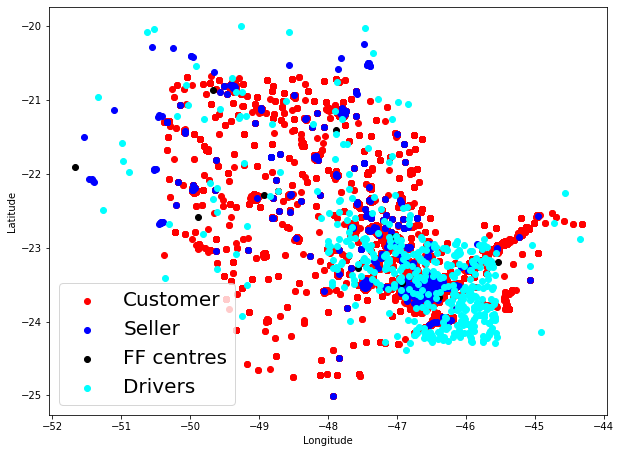

num_constraints: 186466
Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Simplex_Tolerances_Markowitz            0.90000000000000002
CPXPARAM_Simplex_Tolerances_Optimality           1.0000000000000001e-09
CPXPARAM_Simplex_Tolerances_Feasibility          1.0000000000000001e-09
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 0 rows and 825200 columns.
Reduced LP has 186466 rows, 92860 columns, and 632900 nonzeros.
Presolve time = 0.72 sec. (368.48 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =             2.201320
Iteration:    53   Dual objective     =             3.679145
Initializing dual steep norms . . .
Iteration:    54   Dual objective     =             3.681018
Iteration:  1164   Dual objective    

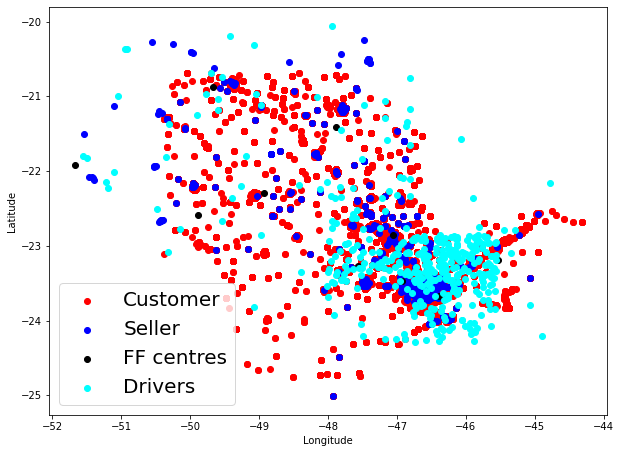

num_constraints: 177654
Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Simplex_Tolerances_Markowitz            0.90000000000000002
CPXPARAM_Simplex_Tolerances_Optimality           1.0000000000000001e-09
CPXPARAM_Simplex_Tolerances_Feasibility          1.0000000000000001e-09
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 0 rows and 689810 columns.
Reduced LP has 177654 rows, 88340 columns, and 602620 nonzeros.
Presolve time = 0.72 sec. (331.97 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =             1.953126
Iteration:    55   Dual objective     =             3.612742
Initializing dual steep norms . . .
Iteration:    56   Dual objective     =             3.612970
Iteration:  1030   Dual objective    

[ Raw Info all runs for each dist_type ] :
     Dist Type   Gini  Avg Dist  Income_Gap  spatial_index
0      Random  0.058      1.62        0.50         0.0172
1        LIPA  0.007      1.36        0.13         0.0041
2  RoundRobin  0.065      1.57        0.30         0.0094
3        MCCA  0.045      0.53        0.10         0.0039
4      MCCA-L  0.045      0.53        0.10         0.0039
5  FairAssign  0.042      0.95        0.25         0.0066
[ Mean for each Dist Type ] :
              Gini  Avg Dist  Income_Gap  spatial_index
Dist Type                                             
FairAssign  0.042      0.95        0.25         0.0066
LIPA        0.007      1.36        0.13         0.0041
MCCA        0.045      0.53        0.10         0.0039
MCCA-L      0.045      0.53        0.10         0.0039
Random      0.058      1.62        0.50         0.0172
RoundRobin  0.065      1.57        0.30         0.0094

[ Max for each Dist Type ] :
              Gini  Avg Dist  Income_Gap  spatial

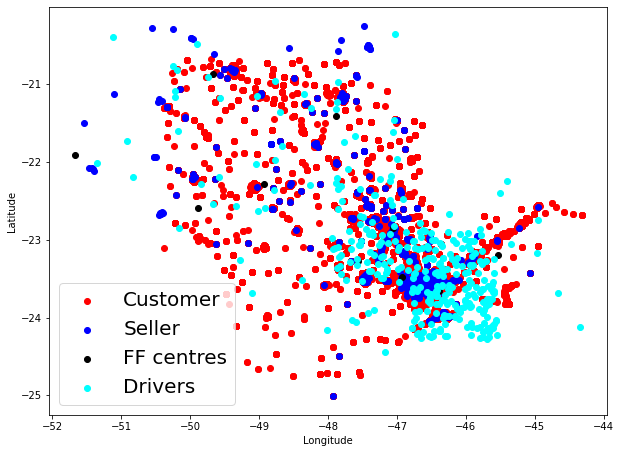

num_constraints: 125745
Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Simplex_Tolerances_Markowitz            0.90000000000000002
CPXPARAM_Simplex_Tolerances_Optimality           1.0000000000000001e-09
CPXPARAM_Simplex_Tolerances_Feasibility          1.0000000000000001e-09
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 0 rows and 496400 columns.
Reduced LP has 125745 rows, 63050 columns, and 427990 nonzeros.
Presolve time = 0.49 sec. (236.63 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =             1.632139
Iteration:   454   Dual objective     =             2.897724
Iteration:  1043   Dual objective     =             3.766932
Iteration:  1998   Dual objective    

[ Raw Info all runs for each dist_type ] :
      Dist Type   Gini  Avg Dist  Income_Gap  spatial_index
0       Random  0.058      1.62        0.50         0.0172
1         LIPA  0.007      1.36        0.13         0.0041
2   RoundRobin  0.065      1.57        0.30         0.0094
3         MCCA  0.045      0.53        0.10         0.0039
4       MCCA-L  0.045      0.53        0.10         0.0039
5   FairAssign  0.042      0.95        0.25         0.0066
6       Random  0.107      1.77        1.35         0.0284
7         LIPA  0.032      1.15        0.39         0.0070
8   RoundRobin  0.053      1.74        0.82         0.0139
9         MCCA  0.151      0.48        0.02         0.0420
10      MCCA-L  0.151      0.48        0.02         0.0420
11  FairAssign  0.095      0.93        1.05         0.0186
[ Mean for each Dist Type ] :
               Gini  Avg Dist  Income_Gap  spatial_index
Dist Type                                              
FairAssign  0.0685     0.940       0.650      

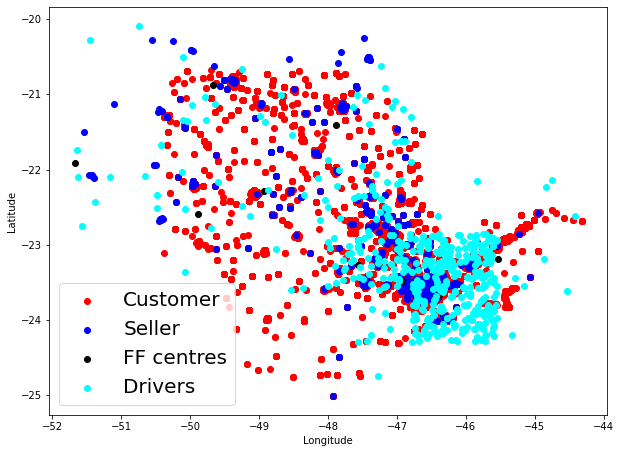

num_constraints: 231808
Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Simplex_Tolerances_Markowitz            0.90000000000000002
CPXPARAM_Simplex_Tolerances_Optimality           1.0000000000000001e-09
CPXPARAM_Simplex_Tolerances_Feasibility          1.0000000000000001e-09
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 0 rows and 909100 columns.
Reduced LP has 231808 rows, 114680 columns, and 784680 nonzeros.
Presolve time = 0.94 sec. (434.78 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =             2.288801
Iteration:    64   Dual objective     =             4.220640
Initializing dual steep norms . . .
Iteration:    65   Dual objective     =             4.220652
Iteration:  1329   Dual objective   

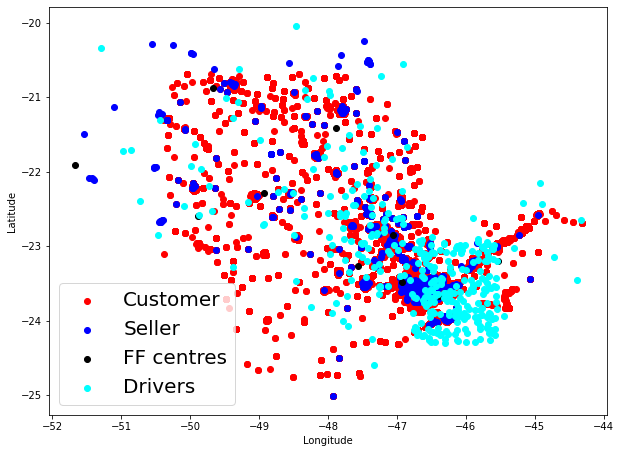

num_constraints: 125278
Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Simplex_Tolerances_Markowitz            0.90000000000000002
CPXPARAM_Simplex_Tolerances_Optimality           1.0000000000000001e-09
CPXPARAM_Simplex_Tolerances_Feasibility          1.0000000000000001e-09
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 0 rows and 551270 columns.
Reduced LP has 125278 rows, 62980 columns, and 426860 nonzeros.
Presolve time = 0.50 sec. (247.04 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =             1.928994
Iteration:   466   Dual objective     =             3.532060
Iteration:  1040   Dual objective     =             4.573322
Iteration:  1984   Dual objective    

[ Raw Info all runs for each dist_type ] :
      Dist Type   Gini  Avg Dist  Income_Gap  spatial_index
0       Random  0.058      1.62        0.50         0.0172
1         LIPA  0.007      1.36        0.13         0.0041
2   RoundRobin  0.065      1.57        0.30         0.0094
3         MCCA  0.045      0.53        0.10         0.0039
4       MCCA-L  0.045      0.53        0.10         0.0039
5   FairAssign  0.042      0.95        0.25         0.0066
6       Random  0.107      1.77        1.35         0.0284
7         LIPA  0.032      1.15        0.39         0.0070
8   RoundRobin  0.053      1.74        0.82         0.0139
9         MCCA  0.151      0.48        0.02         0.0420
10      MCCA-L  0.151      0.48        0.02         0.0420
11  FairAssign  0.095      0.93        1.05         0.0186
12      Random  0.096      1.80        1.53         0.0234
13        LIPA  0.009      1.24        0.26         0.0031
14  RoundRobin  0.067      1.80        1.12         0.0157
15        MC

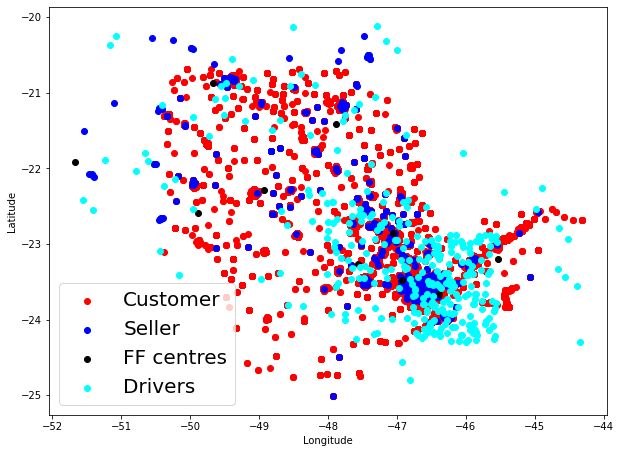

num_constraints: 97296
Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Simplex_Tolerances_Markowitz            0.90000000000000002
CPXPARAM_Simplex_Tolerances_Optimality           1.0000000000000001e-09
CPXPARAM_Simplex_Tolerances_Feasibility          1.0000000000000001e-09
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 0 rows and 461040 columns.
Reduced LP has 97296 rows, 49360 columns, and 332760 nonzeros.
Presolve time = 0.40 sec. (198.49 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =             1.889661
Iteration:   431   Dual objective     =             3.312224
Iteration:  1008   Dual objective     =             4.267404
Iteration:  1794   Dual objective     =

[ Raw Info all runs for each dist_type ] :
      Dist Type   Gini  Avg Dist  Income_Gap  spatial_index
0       Random  0.058      1.62        0.50         0.0172
1         LIPA  0.007      1.36        0.13         0.0041
2   RoundRobin  0.065      1.57        0.30         0.0094
3         MCCA  0.045      0.53        0.10         0.0039
4       MCCA-L  0.045      0.53        0.10         0.0039
5   FairAssign  0.042      0.95        0.25         0.0066
6       Random  0.107      1.77        1.35         0.0284
7         LIPA  0.032      1.15        0.39         0.0070
8   RoundRobin  0.053      1.74        0.82         0.0139
9         MCCA  0.151      0.48        0.02         0.0420
10      MCCA-L  0.151      0.48        0.02         0.0420
11  FairAssign  0.095      0.93        1.05         0.0186
12      Random  0.096      1.80        1.53         0.0234
13        LIPA  0.009      1.24        0.26         0.0031
14  RoundRobin  0.067      1.80        1.12         0.0157
15        MC

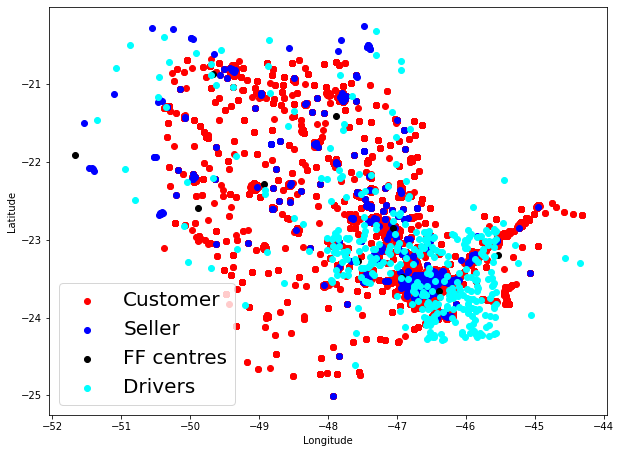

num_constraints: 118377
Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Simplex_Tolerances_Markowitz            0.90000000000000002
CPXPARAM_Simplex_Tolerances_Optimality           1.0000000000000001e-09
CPXPARAM_Simplex_Tolerances_Feasibility          1.0000000000000001e-09
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 0 rows and 582840 columns.
Reduced LP has 118377 rows, 59770 columns, and 404070 nonzeros.
Presolve time = 0.50 sec. (245.79 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =             1.845115
Iteration:   435   Dual objective     =             3.305978
Iteration:   996   Dual objective     =             4.386702
Iteration:  1805   Dual objective    

[ Raw Info all runs for each dist_type ] :
      Dist Type   Gini  Avg Dist  Income_Gap  spatial_index
0       Random  0.058      1.62        0.50         0.0172
1         LIPA  0.007      1.36        0.13         0.0041
2   RoundRobin  0.065      1.57        0.30         0.0094
3         MCCA  0.045      0.53        0.10         0.0039
4       MCCA-L  0.045      0.53        0.10         0.0039
5   FairAssign  0.042      0.95        0.25         0.0066
6       Random  0.107      1.77        1.35         0.0284
7         LIPA  0.032      1.15        0.39         0.0070
8   RoundRobin  0.053      1.74        0.82         0.0139
9         MCCA  0.151      0.48        0.02         0.0420
10      MCCA-L  0.151      0.48        0.02         0.0420
11  FairAssign  0.095      0.93        1.05         0.0186
12      Random  0.096      1.80        1.53         0.0234
13        LIPA  0.009      1.24        0.26         0.0031
14  RoundRobin  0.067      1.80        1.12         0.0157
15        MC

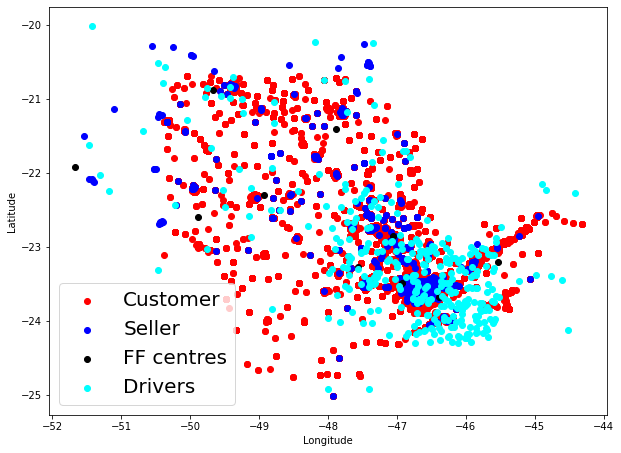

num_constraints: 123734
Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Simplex_Tolerances_Markowitz            0.90000000000000002
CPXPARAM_Simplex_Tolerances_Optimality           1.0000000000000001e-09
CPXPARAM_Simplex_Tolerances_Feasibility          1.0000000000000001e-09
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 0 rows and 514160 columns.
Reduced LP has 123734 rows, 62140 columns, and 421420 nonzeros.
Presolve time = 0.52 sec. (237.98 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =             1.857166
Iteration:   446   Dual objective     =             3.365733
Iteration:   997   Dual objective     =             4.368489
Iteration:  1788   Dual objective    

[ Raw Info all runs for each dist_type ] :
      Dist Type   Gini  Avg Dist  Income_Gap  spatial_index
0       Random  0.058      1.62        0.50         0.0172
1         LIPA  0.007      1.36        0.13         0.0041
2   RoundRobin  0.065      1.57        0.30         0.0094
3         MCCA  0.045      0.53        0.10         0.0039
4       MCCA-L  0.045      0.53        0.10         0.0039
5   FairAssign  0.042      0.95        0.25         0.0066
6       Random  0.107      1.77        1.35         0.0284
7         LIPA  0.032      1.15        0.39         0.0070
8   RoundRobin  0.053      1.74        0.82         0.0139
9         MCCA  0.151      0.48        0.02         0.0420
10      MCCA-L  0.151      0.48        0.02         0.0420
11  FairAssign  0.095      0.93        1.05         0.0186
12      Random  0.096      1.80        1.53         0.0234
13        LIPA  0.009      1.24        0.26         0.0031
14  RoundRobin  0.067      1.80        1.12         0.0157
15        MC

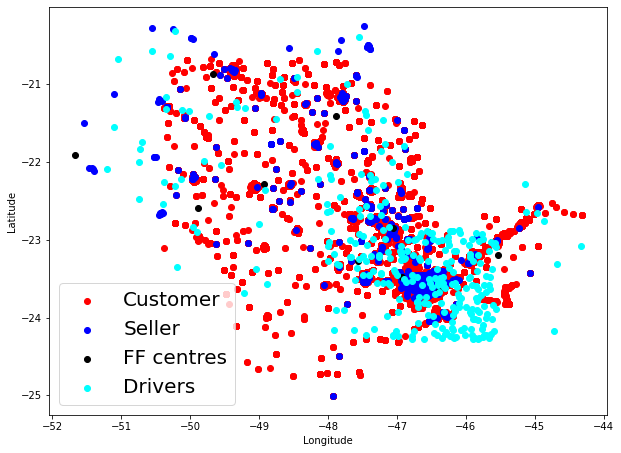

num_constraints: 78904
Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Simplex_Tolerances_Markowitz            0.90000000000000002
CPXPARAM_Simplex_Tolerances_Optimality           1.0000000000000001e-09
CPXPARAM_Simplex_Tolerances_Feasibility          1.0000000000000001e-09
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 0 rows and 417090 columns.
Reduced LP has 78904 rows, 40440 columns, and 271000 nonzeros.
Presolve time = 0.36 sec. (169.65 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =             1.796818
Iteration:   389   Dual objective     =             3.008447
Iteration:   915   Dual objective     =             3.956007
Iteration:  1615   Dual objective     =

[ Raw Info all runs for each dist_type ] :
      Dist Type   Gini  Avg Dist  Income_Gap  spatial_index
0       Random  0.058      1.62        0.50         0.0172
1         LIPA  0.007      1.36        0.13         0.0041
2   RoundRobin  0.065      1.57        0.30         0.0094
3         MCCA  0.045      0.53        0.10         0.0039
4       MCCA-L  0.045      0.53        0.10         0.0039
5   FairAssign  0.042      0.95        0.25         0.0066
6       Random  0.107      1.77        1.35         0.0284
7         LIPA  0.032      1.15        0.39         0.0070
8   RoundRobin  0.053      1.74        0.82         0.0139
9         MCCA  0.151      0.48        0.02         0.0420
10      MCCA-L  0.151      0.48        0.02         0.0420
11  FairAssign  0.095      0.93        1.05         0.0186
12      Random  0.096      1.80        1.53         0.0234
13        LIPA  0.009      1.24        0.26         0.0031
14  RoundRobin  0.067      1.80        1.12         0.0157
15        MC

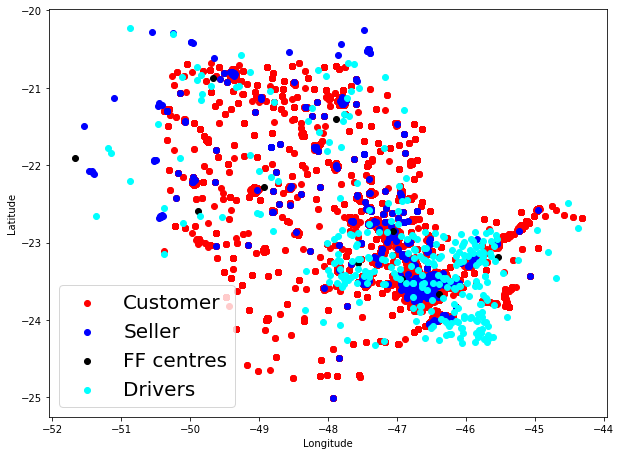

num_constraints: 72176
Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Simplex_Tolerances_Markowitz            0.90000000000000002
CPXPARAM_Simplex_Tolerances_Optimality           1.0000000000000001e-09
CPXPARAM_Simplex_Tolerances_Feasibility          1.0000000000000001e-09
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 0 rows and 396490 columns.
Reduced LP has 72176 rows, 37160 columns, and 248360 nonzeros.
Presolve time = 0.33 sec. (158.23 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =             1.413034
Iteration:   388   Dual objective     =             2.703200
Iteration:   862   Dual objective     =             3.709604
Iteration:  1528   Dual objective     =

[ Raw Info all runs for each dist_type ] :
      Dist Type   Gini  Avg Dist  Income_Gap  spatial_index
0       Random  0.058      1.62        0.50         0.0172
1         LIPA  0.007      1.36        0.13         0.0041
2   RoundRobin  0.065      1.57        0.30         0.0094
3         MCCA  0.045      0.53        0.10         0.0039
4       MCCA-L  0.045      0.53        0.10         0.0039
5   FairAssign  0.042      0.95        0.25         0.0066
6       Random  0.107      1.77        1.35         0.0284
7         LIPA  0.032      1.15        0.39         0.0070
8   RoundRobin  0.053      1.74        0.82         0.0139
9         MCCA  0.151      0.48        0.02         0.0420
10      MCCA-L  0.151      0.48        0.02         0.0420
11  FairAssign  0.095      0.93        1.05         0.0186
12      Random  0.096      1.80        1.53         0.0234
13        LIPA  0.009      1.24        0.26         0.0031
14  RoundRobin  0.067      1.80        1.12         0.0157
15        MC

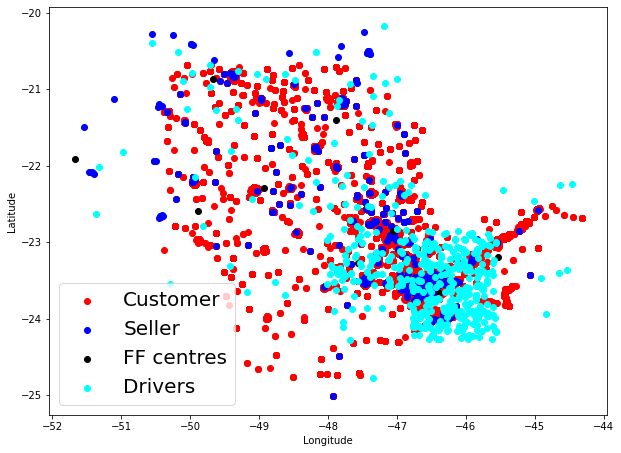

num_constraints: 202058
Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Simplex_Tolerances_Markowitz            0.90000000000000002
CPXPARAM_Simplex_Tolerances_Optimality           1.0000000000000001e-09
CPXPARAM_Simplex_Tolerances_Feasibility          1.0000000000000001e-09
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 0 rows and 861030 columns.
Reduced LP has 202058 rows, 100380 columns, and 685140 nonzeros.
Presolve time = 0.87 sec. (392.69 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =             2.153147
Iteration:    55   Dual objective     =             3.642194
Initializing dual steep norms . . .
Iteration:    56   Dual objective     =             3.642504
Iteration:   967   Dual objective   

Number of Drivers: 308


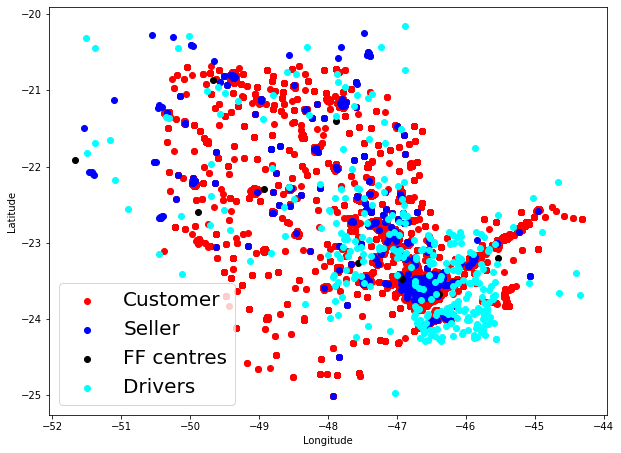

num_constraints: 86932
Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Simplex_Tolerances_Markowitz            0.90000000000000002
CPXPARAM_Simplex_Tolerances_Optimality           1.0000000000000001e-09
CPXPARAM_Simplex_Tolerances_Feasibility          1.0000000000000001e-09
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 0 rows and 431540 columns.
Reduced LP has 86932 rows, 44320 columns, and 297920 nonzeros.
Presolve time = 0.33 sec. (181.30 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =             1.841961
Iteration:   393   Dual objective     =             3.061370
Iteration:   901   Dual objective     =             4.262669
Iteration:  1516   Dual objective     =

[ Raw Info all runs for each dist_type ] :
      Dist Type   Gini  Avg Dist  Income_Gap  spatial_index
0       Random  0.058      1.62        0.50         0.0172
1         LIPA  0.007      1.36        0.13         0.0041
2   RoundRobin  0.065      1.57        0.30         0.0094
3         MCCA  0.045      0.53        0.10         0.0039
4       MCCA-L  0.045      0.53        0.10         0.0039
5   FairAssign  0.042      0.95        0.25         0.0066
6       Random  0.107      1.77        1.35         0.0284
7         LIPA  0.032      1.15        0.39         0.0070
8   RoundRobin  0.053      1.74        0.82         0.0139
9         MCCA  0.151      0.48        0.02         0.0420
10      MCCA-L  0.151      0.48        0.02         0.0420
11  FairAssign  0.095      0.93        1.05         0.0186
12      Random  0.096      1.80        1.53         0.0234
13        LIPA  0.009      1.24        0.26         0.0031
14  RoundRobin  0.067      1.80        1.12         0.0157
15        MC

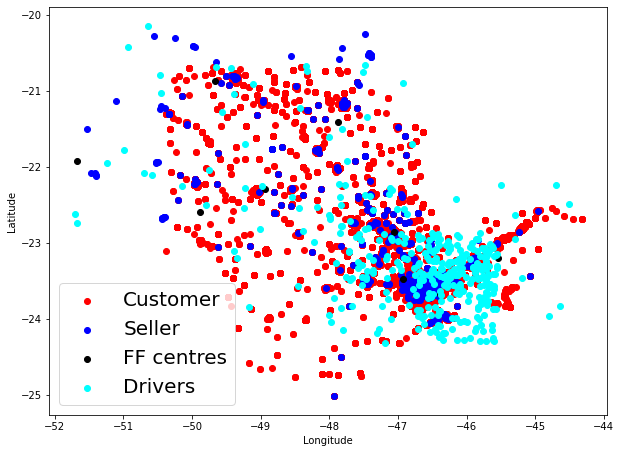

num_constraints: 145278
Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Simplex_Tolerances_Markowitz            0.90000000000000002
CPXPARAM_Simplex_Tolerances_Optimality           1.0000000000000001e-09
CPXPARAM_Simplex_Tolerances_Feasibility          1.0000000000000001e-09
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 0 rows and 570030 columns.
Reduced LP has 145278 rows, 72580 columns, and 493740 nonzeros.
Presolve time = 0.56 sec. (272.70 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =             1.758065
Iteration:    48   Dual objective     =             3.155071
Initializing dual steep norms . . .
Iteration:    49   Dual objective     =             3.155632
Iteration:  1054   Dual objective    

[ Raw Info all runs for each dist_type ] :
      Dist Type   Gini  Avg Dist  Income_Gap  spatial_index
0       Random  0.058      1.62        0.50         0.0172
1         LIPA  0.007      1.36        0.13         0.0041
2   RoundRobin  0.065      1.57        0.30         0.0094
3         MCCA  0.045      0.53        0.10         0.0039
4       MCCA-L  0.045      0.53        0.10         0.0039
5   FairAssign  0.042      0.95        0.25         0.0066
6       Random  0.107      1.77        1.35         0.0284
7         LIPA  0.032      1.15        0.39         0.0070
8   RoundRobin  0.053      1.74        0.82         0.0139
9         MCCA  0.151      0.48        0.02         0.0420
10      MCCA-L  0.151      0.48        0.02         0.0420
11  FairAssign  0.095      0.93        1.05         0.0186
12      Random  0.096      1.80        1.53         0.0234
13        LIPA  0.009      1.24        0.26         0.0031
14  RoundRobin  0.067      1.80        1.12         0.0157
15        MC

In [26]:
Gini_Index_List = []
Avg_Distance_List = []
Income_Gap_List = []
spatial_inequality_list = []
Name_list = []
Income_sum_lis = []
num_drivers = []
fraction_list = []

import copy

def sanityCheck(weights):
    """
    To cope with bound violations which can occur upto the feasibility parameter range 
    So the lower bound of 0.0 on the probabilities can get violated and the values can go down to (0-feasibility_parameter_value)
    """
    for i in range(len(weights)):
        last_pos_index = -1
        neg_value = 0
        
        for j in range(len(weights[0])):
            assert weights[i][j] > -1e-5 
            if weights[i][j] < 0:
                neg_value += weights[i][j]
                weights[i][j] = 0
            elif weights[i][j] > 0:
                last_pos_index = j
        
        weights[i][last_pos_index] += neg_value
        
    return weights

number_of_runs = int(configParser.get('dataset-generation','number_of_runs'))
random_seed = int(configParser.get('dataset-generation','random_seed'))

dis_type = ["random","low_income_dist","round_robin","vanilla_max","vanilla_maxmin","fair_algo"]
Name_dis_types = ["Random","LIPA","RoundRobin","MCCA","MCCA-L","FairAssign"]
colors = ['Indigo','Blue','Cyan','Green','Orange','Red']

indexs_allowed = [0,1,2,3,4,5] 

# data to be stored for scatter income plot and lorenz curve plot:
driver_income_dfs = {dist:{} for dist in dis_type} 
income_arrs = {dist:{} for dist in dis_type}
centre = final_ffc_locs

# Generates result for number_of_runs times, and store the value in differnt list
for i in range(number_of_runs):
    print(f"----------- Run {i+1} ------------------")
    new_drivers = driver_generation(i+random.randint(0, 100))
    # new_drivers = driver_locs
    
    if len(new_drivers) < sum(lower_cap):
        print("Lower number of drivers generated")
        print(f"Generated: {len(new_drivers)}, Required: {sum(lower_cap)}")
        i -= 1
        continue
    
    ratings = generate_ratings(new_drivers.shape[0])
    result, feasible = fair_clustering(new_drivers,centre,ratings)
    num_samples = len(new_drivers)
    num_centres = len(centre)
    
    # Since the assignment can be infeasible if sum(upper_cap)<num_samples, therefore perform driver generation until feasibility is attained !
    while not feasible:
        new_drivers = driver_generation(i+random.randint(0, 100))
        num_samples = len(new_drivers)
        ratings = generate_ratings(new_drivers.shape[0])
        result, feasible = fair_clustering(new_drivers,centre,ratings)
        
    # Probability Distribution output from cplex
    lpp_prob_dis = np.reshape(result['assignment'][:num_samples*num_centres],(-1,num_centres))
    lpp_prob_dis = sanityCheck(copy.deepcopy(lpp_prob_dis))
        
    
    print("Everything solved, graphs start")
    
    for j in indexs_allowed:
        tup = inequality2(algo_type=dis_type[j],lpp_prob_dis=lpp_prob_dis)
        tup2 = helper_func(tup[2],new_drivers,ratings)
        spat = spatial_inequality(tup2[1], tup2[2], tup2[3], new_drivers,ratings)

        Gini_Index_List.append(tup[0])
        Avg_Distance_List.append(tup[1])
        Income_Gap_List.append(tup2[0])
        spatial_inequality_list.append(spat)
        Name_list.append(Name_dis_types[j])
        Income_sum_lis.append(tup[3])
        num_drivers.append(num_samples)
        
        # for scatter income plot for FairAssign:
        driver_income_dfs[dis_type[j]] = tup[2]
        # for lorenz curve:
        income_arrs[dis_type[j]] = tup[4]
        
        if j==3: base=tup2[3] # MCCA
        if j==5: fair=tup2[3] # FairAssign
    
    fraction_worse_off = fraction(base,fair)
    fraction_list.append(fraction_worse_off)

    # Below All_Income contains all info about all runs
    All_Income = pd.DataFrame({'Dist Type':Name_list,'Gini': Gini_Index_List,'Avg Dist':Avg_Distance_List,'Income_Gap':Income_Gap_List,'spatial_index':spatial_inequality_list})
    print("[ Raw Info all runs for each dist_type ] :\n", All_Income)
    print("[ Mean for each Dist Type ] :\n", All_Income.groupby('Dist Type').mean())
    print()
    print("[ Max for each Dist Type ] :\n", All_Income.groupby('Dist Type').max())
    print()
    print("[ Min for each Dist Type ] :\n", All_Income.groupby('Dist Type').min())
    print()



In [27]:
# Print all the result
All_Income = pd.DataFrame({'Dist Type':Name_list,'Gini': Gini_Index_List, 'Avg Dist':Avg_Distance_List,'Income_Gap':Income_Gap_List,'spatial_index':spatial_inequality_list,'Income_sum':Income_sum_lis})
All_Income = All_Income.replace("Low Income Distribution","Robinhood") # just as cool line! no meaning

# configParser.read(configFilePath)
print("State: ",configParser.get('dataset-generation','state'))
# print("Equal_to_or_not: ",configParser.get('dataset-generation','equal_to'))
print("num_ffc_center: ",configParser.get('dataset-generation','num_ffc_center'))
print("Grid Size: ",configParser.get('dataset-generation','grid_length'),configParser.get('dataset-generation','grid_width'))
print("Fair Distance: ",configParser.get('fairness-constraint','fair_distance'))
print("Alpha_fair: ",configParser.get('fairness-constraint','alpha_fair'))
print("number_of_runs: ",configParser.get('dataset-generation','number_of_runs'))
print()
print("Avg Num of Drivers: ",np.mean(np.array(num_drivers)))
print() 

print("#################################### FINAL RESULTS #######################################################")
print("[ Mean for each Dist Type ] :")
print(All_Income.groupby('Dist Type').mean().round(4))
print()
print("[ Max for each Dist Type ] :\n")
print(All_Income.groupby('Dist Type').max())
print()
print("[ Min for each Dist Type ] :\n")
print(All_Income.groupby('Dist Type').min())
print()

State:  SP
num_ffc_center:  10
Grid Size:  7 7
Fair Distance:  0.1
Alpha_fair:  2
number_of_runs:  10

Avg Num of Drivers:  335.6

#################################### FINAL RESULTS #######################################################
[ Mean for each Dist Type ] :
              Gini  Avg Dist  Income_Gap  spatial_index  Income_sum
Dist Type                                                          
FairAssign  0.0776     0.973       0.800         0.0119   33931.385
LIPA        0.0187     1.275       0.335         0.0053   30047.568
MCCA        0.1534     0.517       0.660         0.0247   33993.526
MCCA-L      0.1521     0.517       0.700         0.0255   33993.166
Random      0.1057     1.827       1.302         0.0230   33930.704
RoundRobin  0.0721     1.825       0.911         0.0143   33930.584

[ Max for each Dist Type ] :

             Gini  Avg Dist  Income_Gap  spatial_index  Income_sum
Dist Type                                                         
FairAssign  0.129      